In [3]:
import pandas as pd
df = pd.read_csv('/Users/johnathanhou/Desktop/ECS 111/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
# V1 ~ V28: may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)
# Amount: the transaction amount 
# Class : 1 in case of fraud, 0 otherwise

In [5]:
df['Class'].value_counts(normalize = True) # imbalanced dataset

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [7]:
# Since V1 ~ V28 columns are results of a PCA dimensionality reduction, we don't need to do any preprocessing
# Feature scaling column "Amount" and "Time"

from sklearn.preprocessing import StandardScaler
df['scaled_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025, stratify = y)

# Applying SMOTE (oversampling)
smote = SMOTE(random_state = 2025)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state = 2025)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Random Forest output
- Recall = 0.84 -> correctly finds 84% of true fraud action
- Precision = 0.87 -> 87% of our y_pred were actual fraud action
- F1-score = 0.85 -> output is well-balanced
- Since accuracy of 1 is too high, looking at recall / precision will be more trustworthy

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 2025)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
xgb_report = classification_report(y_test, y_pred_xgb)
print(xgb_report)

/Users/johnathanhou/Desktop/Anaconda/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.84      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



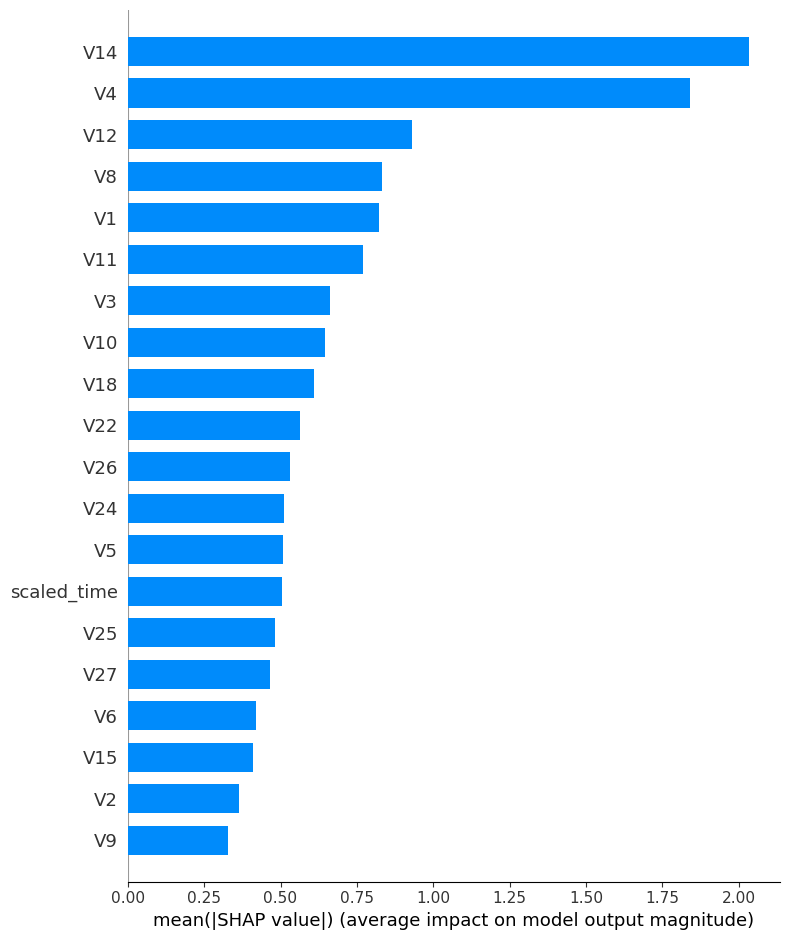

In [16]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = 'bar')

# XGBoost output
- Recall = 0.84 -> correctly finds 84% of true fraud action
- Precision = 0.79 -> 79% of our y_pred were actual fraud action
- F1-score = 0.81 -> output is well-balanced

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

mlp = MLPClassifier(max_iter = 200, random_state = 2025)

param_grid = {
    'hidden_layer_sizes' : [(64, 32), (128, 32), (64, 64)],
    'activation': ['relu', 'tanh'],
    'alpha' : [0.0001, 0.001, 0.01],
    'learning_rate_init' : [0.001, 0.01]
}

grid_search = GridSearchCV(mlp, param_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 1)

grid_search.fit(X_train_resampled, y_train_resampled)

print('Best parameters: ', grid_search.best_params_)
print('Best F1 score on validation set: ', grid_search.best_score_)

y_pred_mlp = grid_search.predict(X_test)
mlp_report = classification_report(y_test, y_pred_mlp)
print("Classification Report: ")
print(mlp_report)

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_mlp))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}
Best F1 score on validation set:  0.9997802237404858
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
[[56846    18]
 [   19    79]]


# Multi-Layer Perceptron output
- Best Recall = 0.77 -> correctly finds 77% of true fraud action
- Best Precision = 0.86 -> 86% of our y_pred were actual fraud action
- Best F1-score = 0.81

In [65]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=2025)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.60      0.70        98

    accuracy                           1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



# Logistic Regression output
- Recall = 0.60 -> correctly finds 60% of true fraud action
- Precision = 0.84 -> 84% of our positive predictions were actually fraud
- F1-score = 0.70 -> output is moderately balanced, but it tends to miss some fraud cases

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.78      0.87        98

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



# K-Nearest neighbors output
- Recall = 0.78 -> correctly finds 78% of true fraud action
- Precision = 1.00 -> all predicted fraud cases were actually fraud
- F1-score = 0.87 -> strong performance with very low false prositives and decent recall

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [85]:
y_pred_rf_prob = rf.predict_proba(X_test)[:,1]
y_pred_xg_prob = xgb.predict_proba(X_test)[:,1]
y_pred_mlp_prob = grid_search.predict_proba(X_test)[:,1]
y_pred_log_prob = log_reg.predict_proba(X_test)[:,1]
y_pred_knn_prob = knn.predict_proba(X_test_scaled)[:,1]

In [86]:
test_df = pd.DataFrame(
    {'True': y_test, 'Logistic Regression': y_pred_log_prob, 
     'K-Nearest Neighbours': y_pred_knn_prob, 
     'RandomForest': y_pred_rf_prob, 'XGBoost': y_pred_xg_prob, 
     'Multi-Layer Perceptron': y_pred_mlp_prob}
)

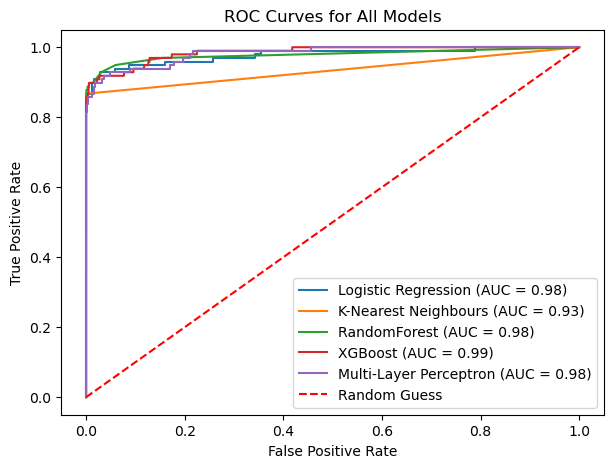

In [87]:
plt.figure(figsize=(7, 5))

for model in ['Logistic Regression', 'K-Nearest Neighbours',
              'RandomForest', 'XGBoost', 'Multi-Layer Perceptron']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

In [37]:
y_test

89465     0
198132    0
65776     0
194758    0
236040    0
         ..
4164      0
146663    0
66854     0
123241    0
243077    0
Name: Class, Length: 56962, dtype: int64

56962

TypeError: 'DataFrame' object is not callable